# COVID-19 cases by country

JHU dataset: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv

In [1]:
# Plots inline with the code
%matplotlib inline

# Data manipulation and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Libraries to read data from web downloads and generate a dataframe
import requests
from io import StringIO


In [2]:
# Sets the notebook to use the full width of the window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

## Datasets

* Grab the new data via HTTPS
* Transform the awkward table into column format with a section for each country
* Group by country
* Count number of days since first reported case

In [3]:
url_prefix = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/'
# Get data via github
# Transform awkward JHU table
def get_jhu_dataset(data_file):
    # Get the latest updates from JHU via github
    data_web = requests.get('{}{}'.format(url_prefix, data_file), allow_redirects=True)
    data_io = StringIO(data_web.text)
    df = pd.read_csv(data_io)
    df.drop(['Long', 'Lat'], axis=1, inplace=True)

    # Break the akward table into sections for each country
    df_list = list()
    for c in set(df['Country/Region']):
        country = c
        totals = df[df['Country/Region'] == country].sum()
        daily_new_cases = totals[2:].diff()
        # Place back first row
        daily_new_cases[0] = totals[2]
        df_country = pd.DataFrame(daily_new_cases)
        df_country = df_country.rename(columns={0:'daily_new_cases'})
        df_country['country'] = country
        df_list.append(df_country)
        
    # Put all sections of countries into a single dataframe
    df_all = pd.concat(df_list)
    df_all = df_all.reset_index().rename(columns={'index':'date'})
    df_all = df_all[df_all['daily_new_cases'] > 0]
    df_all['date'] = pd.to_datetime(df_all['date'])
    return df_all


In [4]:
def get_topN_by_total(df, number_countries):
    groups =  df.groupby('country')
    top_n = list(groups['daily_new_cases'].sum().sort_values(ascending=False).keys()[0:number_countries])
    return top_n

# Group by country
# Count days since first reported case
def get_country(df, c):
    first_case = df[df['country'] == c]['date'].min()
    days_since_first_case = df[df['country'] == c]['date'] - first_case
    country_df = pd.DataFrame()
    country_df['days_since_first_case'] = days_since_first_case
    country_df['new_cases'] =  np.int64(df[df['country'] == c]['daily_new_cases'])
    total_cases = country_df['new_cases'].sum()
    country_df['Country'] = '{}: {:,}'.format(c, total_cases)
    country_df['Date'] = df[df['country'] == c]['date'] 
    print('{}: {}'.format(c, total_cases))
    return country_df

def get_topN_countries(df, top_n_countries):
    #top_n_countries = get_topN_by_total(df, number_countries)
    n = len(top_n_countries)
    topN_df = df[df['country'].isin(top_n_countries)]
    df_list = list()
    for c in top_n_countries:
        df_list.append(get_country(df, c))

    countries_df = pd.concat(df_list, ignore_index=True)
    countries_df['days_since_first_case'] = countries_df['days_since_first_case'].dt.days
    return countries_df



In [5]:
def plot_country(country_df, x_label=None, y_label=None):
    if x_label is not None:
        new_x_label = x_label
    else:
        new_x_label = 'days_since_first_case'
    if y_label is not None:
        new_y_label = y_label
    else:
        new_y_label = 'new_cases'
        
    plot_df = country_df.rename(columns={'days_since_first_case':new_x_label, 'new_cases':new_y_label})
        
    sns.set(style="ticks")
    with sns.axes_style("darkgrid"):
        grid = sns.FacetGrid(plot_df, col="Country", hue='Country', col_wrap=1, height=3)
        g = grid.map(plt.plot, new_x_label, new_y_label)
        #g = grid.map(plt.fill_between, new_x_label, new_y_label, alpha=0.2)#.set_titles("{col_name}")
        


def plot_grid(countries_df, col_wrap=4, x_label=None, y_label=None):
    if x_label is not None:
        new_x_label = x_label
    else:
        new_x_label = 'days_since_first_case'
    if y_label is not None:
        new_y_label = y_label
    else:
        new_y_label = 'new_cases'
        
    plot_df = countries_df.rename(columns={'days_since_first_case':new_x_label, 'new_cases':new_y_label})
        
    sns.set(style="ticks")
    with sns.axes_style("darkgrid"):
        grid = sns.FacetGrid(plot_df, col="Country", hue='Country', col_wrap=col_wrap, height=3)
        g = grid.map(plt.plot, new_x_label, new_y_label)
        g = grid.map(plt.fill_between, new_x_label, new_y_label, alpha=0.2).set_titles("{col_name}")
        


# Confirmed cases

US: 83836
China: 81782
Italy: 80589
Spain: 57786
Germany: 43938
France: 29551
Iran: 29406
United Kingdom: 11812
Switzerland: 11811
Korea, South: 9241
Netherlands: 7468
Austria: 6909


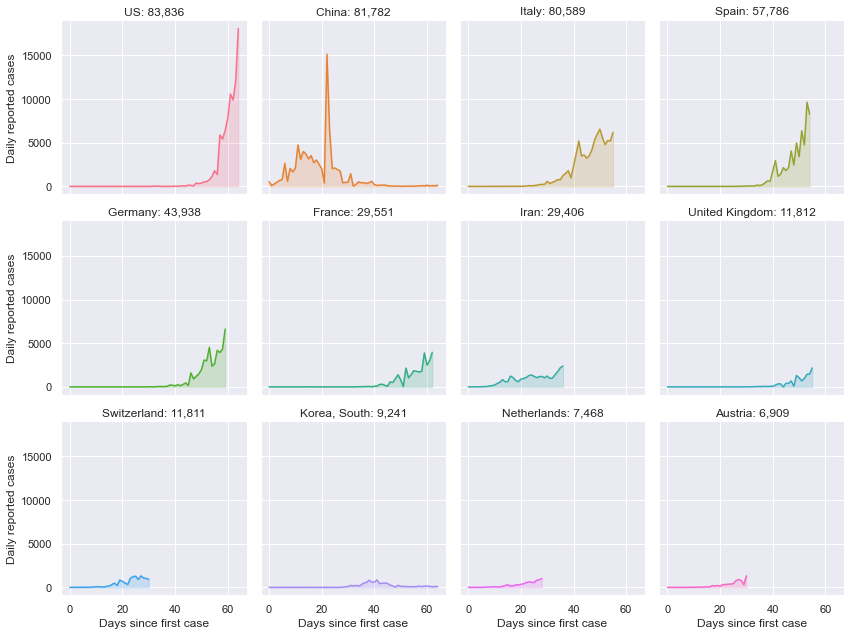

In [6]:
confirmed_df = get_jhu_dataset('time_series_covid19_confirmed_global.csv')
# Get top N by total count.
# We'll use that for other plots
topN_countries_by_total = get_topN_by_total(confirmed_df, 12)
confirmed_countries_df = get_topN_countries(confirmed_df, topN_countries_by_total)
plot_grid(confirmed_countries_df, x_label='Days since first case', y_label='Daily reported cases')


# Deaths

US: 1209
China: 3291
Italy: 8215
Spain: 4365
Germany: 267
France: 1698
Iran: 2234
United Kingdom: 580
Switzerland: 191
Korea, South: 131
Netherlands: 435
Austria: 49


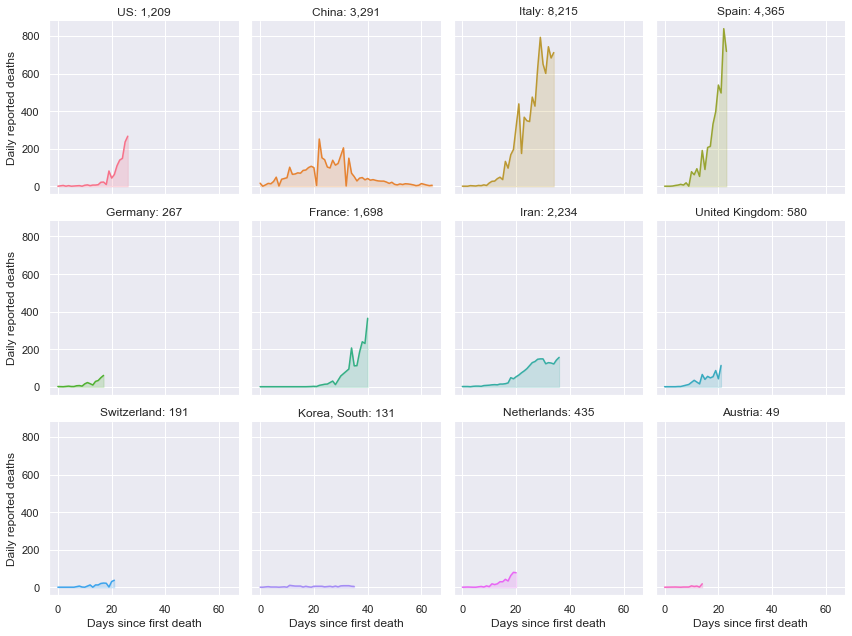

In [7]:
deaths_df = get_jhu_dataset('time_series_covid19_deaths_global.csv')
deaths_countries_df = get_topN_countries(deaths_df, topN_countries_by_total)
plot_grid(deaths_countries_df, x_label='Days since first death', y_label='Daily reported deaths')


In [9]:
deaths_df[deaths_df['country'] == 'US']

,date,daily_new_cases,country
6861,2020-02-29,1,US
6863,2020-03-02,5,US
6864,2020-03-03,1,US
6865,2020-03-04,4,US
6866,2020-03-05,1,US
6867,2020-03-06,2,US
6868,2020-03-07,3,US
6869,2020-03-08,4,US
6870,2020-03-09,1,US
6871,2020-03-10,6,US


## Mauritius and neighbors

Mauritius: 42
Reunion, France: 0
South Africaa: 0
Australiaa: 0


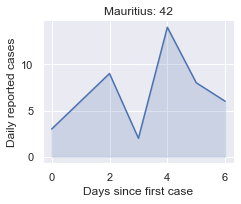

In [30]:
mru_neighbors = ['Mauritius', 'Reunion, France', 'South Africaa', 'Australiaa']
confirmed_countries_df = get_topN_countries(confirmed_df, mru_neighbors)
plot_grid(confirmed_countries_df, x_label='Days since first case', y_label='Daily reported cases')


Mauritius: 2
Reunion, France: 0
South Africaa: 0
Australiaa: 0


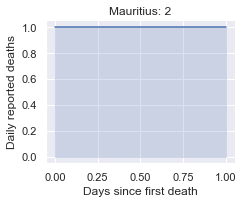

In [25]:
deaths_countries_df = get_topN_countries(deaths_df, mru_neighbors)
plot_grid(deaths_countries_df, x_label='Days since first death', y_label='Daily reported deaths')


In [22]:
confirmed_df[confirmed_df['country'].str.contains('Reunion')]

,date,daily_new_cases,country


In [23]:
set(confirmed_df['country'])

{'Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Diamond Princess',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Grenada',
 'Guatemala',
 'Guinea',
 'Guyana',
 'Haiti',
 'Holy See',
 'Honduras',
 'Hungary',
 'Iceland',
 'In